#### libraries

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as plt_colors
from matplotlib.colorbar import ColorbarBase as plt_colorbase
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('default')

import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

import utils as u

# for interactive plots, uncomment if it causes problems
#%matplotlib widget  

print("% all imported %")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
% all imported %


# Data
---

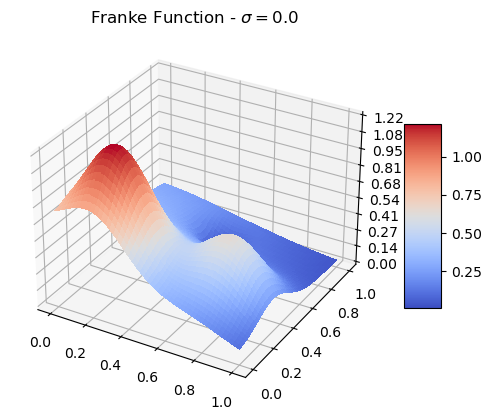

In [2]:
# settings
N = 200
random_ax = False
noise_scale = 0.
scaling = False

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Make data. Use alternatively the uniform distribution
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale, scaling=scaling)

# Plot the surface.
surf = ax.plot_surface(xm, ym, zm, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title(f"Franke Function - $\sigma=${noise_scale}")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# (a) Ordinary Least Square
---

**Model**

In [19]:
# showcase of the polynomial form of the OLS model used below
_ = u.get_coefficients(nb_vars=2, degree=3, verbose=True)

(len: 9) | form z = x^0*y^1 + x^1*y^0 + x^0*y^2 + x^1*y^1 + x^2*y^0 + x^0*y^3 + x^1*y^2 + x^2*y^1 + x^3*y^0 

SETTINGS

In [23]:
# data
N = 30
random_ax = False
noise_scale = 0.1
scaling = False
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale, scaling=scaling)

# model
degrees = range(1, 15)
intercept = True

RUN

In [28]:
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': []}

betas = {}

# split data
x_train, x_test, y_train, y_test, Z_train, Z_test = train_test_split(x, y, z, test_size=0.2)

# run for all degrees
for deg in (bar := tqdm(degrees)):
    
    bar.set_description(f"degree={deg}")

    # define design matrix
    D_train, D_test = u.build_design_matrix(X=x_train, Y=y_train, degree=deg, intercept=intercept), u.build_design_matrix(X=x_test, Y=y_test, degree=deg, intercept=intercept)
        
    # train OLS
    beta, [mse_train, mse_test], [cod_train, cod_test], _ = u.rOLS(dataset_x=[D_train, D_test], 
                                                                             dataset_z=[Z_train, Z_test])
        
    # record
    record['mse_train'] += [mse_train]
    record['cod_train'] += [cod_train]
    record['mse_test'] += [mse_test]
    record['cod_test'] += [cod_test]
    betas[deg] = beta
    
print('.')

degree=14: 100%|█████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 215.84it/s]

.


### Plot results - OLS regression

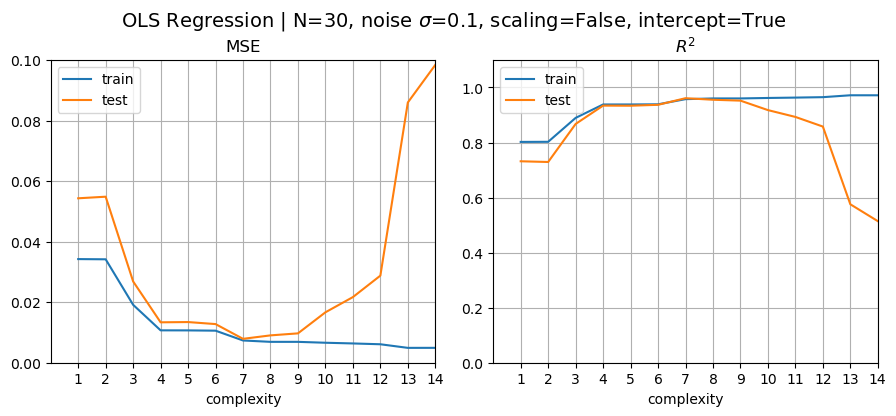

In [29]:
names = tuple(record.keys())
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle(f"OLS Regression | {N=}, noise $\sigma$={noise_scale}, {scaling=}, {intercept=}", fontsize=14)
fig.tight_layout(h_pad=4)

axs[0].plot(degrees, record['mse_train'], label='train')
axs[0].plot(degrees, record['mse_test'], label='test')
axs[0].set_title(f"MSE")
axs[0].set_xlabel('complexity')
axs[0].legend(loc='upper left')
axs[0].set_xticks(degrees)
axs[0].grid()
axs[0].set_ylim((0, 0.1))  # y-axis limits
axs[0].set_xlim((0, degrees[-1]))  # y-axis limits

axs[1].plot(degrees, record['cod_train'], label='train')
axs[1].plot(degrees, record['cod_test'], label='test')
axs[1].set_title("$R^2$")
axs[1].set_xlabel('complexity')
axs[1].legend(loc='upper left')
axs[1].set_xticks(degrees)
axs[1].set_ylim((0, 1.1))
axs[1].set_xlim((0, degrees[-1]))  # y-axis limits
axs[1].grid()

plt.show()

### 3D plot and predictions

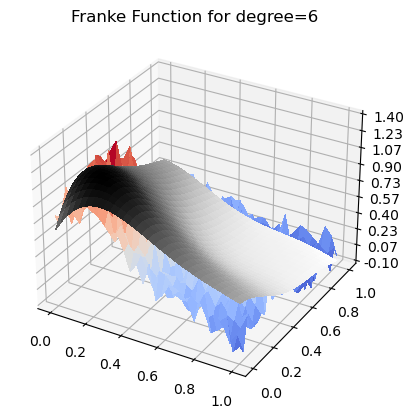

In [30]:
degree = 6

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# get predictions
D = u.build_design_matrix(X=xm, Y=ym, degree=degree, intercept=intercept)
pred = (D @ betas[degree]).squeeze()

# Plot the surface.
surf = ax.plot_surface(xm, ym, zm, cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf2 = ax.plot_surface(xm, ym, pred, cmap='Greys', linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title(f"Franke Function for {degree=}")

plt.show()

---

### Averaged

SETTINGS

In [31]:
# data
N = 100
random_ax = True
noise_scale = 0.2
scaling = False
mean_centering = False
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale, scaling=scaling, mean_center=mean_centering)

# model
degrees = range(1, 11)
intercept = True

nb_iter = 200

RUN

In [32]:
# general record initialization
record = {'avg_train_mse': [],
          'avg_test_mse': [],
          'avg_train_cod': [],
          'avg_test_cod': []}

# split data
x_train, x_test, y_train, y_test, Z_train, Z_test = train_test_split(x, y, z, test_size=0.20)

# run for all degrees
for deg in (bar := tqdm(degrees)):
    
    bar.set_description(f"degree={deg}")
    
    # define design matrix
    D_train, D_test = u.build_design_matrix(X=x_train, Y=y_train, degree=deg, intercept=intercept), u.build_design_matrix(X=x_test, Y=y_test, 
                                                                                                     degree=deg, intercept=intercept)
    
    # record initialization
    avg_train_mse = []
    avg_test_mse = []
    avg_train_cod = []
    avg_test_cod = []
    
    # record initialization
    avg_train_mse_sk = []
    avg_test_mse_sk = []
    avg_train_cod_sk = []
    avg_test_cod_sk = []
    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # iterate $nb_iter times
    for i_ter in range(nb_iter):

        Z_test = Z_test.reshape(-1, 1)

        # train our OLS 
        _, [mse_train, mse_test], [cod_train, cod_test], _ = u.rOLS(dataset_x=[D_train, D_test], 
                                                                    dataset_z=[Z_train, Z_test])

        # record
        avg_train_mse += [mse_train]
        avg_test_mse += [mse_test]
        avg_train_cod += [cod_train]
        avg_test_cod += [cod_test]
        
        # record
        #avg_train_mse_sk += [mse_train_sk]
        #avg_test_mse_sk += [mse_test_sk]
        #avg_train_cod_sk += [cod_train_sk]
        #avg_test_cod_sk += [cod_test_sk]
        
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
    
    # general record
    record['avg_train_mse'] += [np.mean(avg_train_mse)]
    record['avg_test_mse'] += [np.mean(avg_test_mse)]
    record['avg_train_cod'] += [np.mean(avg_train_cod)]
    record['avg_test_cod'] += [np.mean(avg_test_cod)]

print('.')

degree=10: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.85it/s]

.


### Plot results - OLS regression

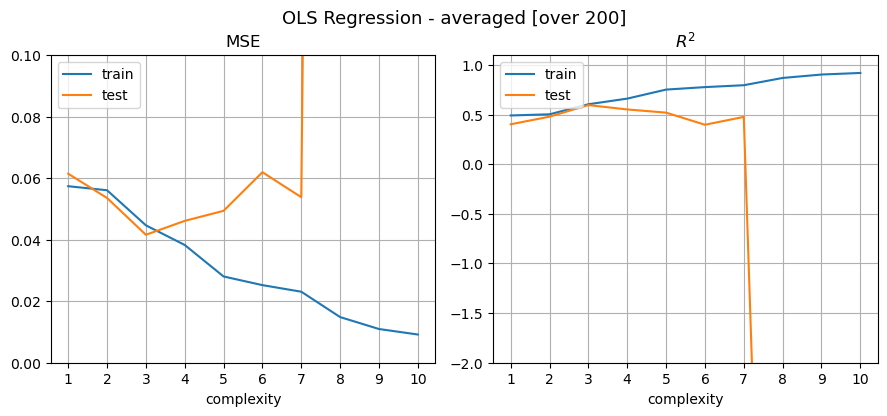

In [33]:
names = tuple(record.keys())
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle(f"OLS Regression - averaged [over {nb_iter}]", 
             fontsize=13)
fig.tight_layout(h_pad=1)

axs[0].plot(degrees, record['avg_train_mse'], '-', label='train')
axs[0].plot(degrees, record['avg_test_mse'], '-', label='test')
axs[0].set_title(f"MSE")
axs[0].set_xlabel('complexity')
axs[0].legend(loc='upper left')
axs[0].set_xticks(degrees)
axs[0].grid()
axs[0].set_ylim((0, 0.1))  # y-axis limits

axs[1].plot(degrees, record['avg_train_cod'], '-', label='train')
axs[1].plot(degrees, record['avg_test_cod'], '-', label='test')
axs[1].set_title(f"$R^2$")
axs[1].set_xlabel('complexity')
axs[1].legend(loc='upper left')
axs[1].set_xticks(degrees)
axs[1].set_ylim((-2, 1.1))  # y-axis limits
axs[1].grid()

plt.show()

# (b) Bootstrap
---

### single run

SETTINGS

In [37]:
# data
N = 25
random_ax = False
noise_scale = 0.03
scaling = False
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale, scaling=scaling)

# model
degrees = range(1, 11)
nb_bootstraps = 200
intercept = True

RUN

In [44]:
# prepare record
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': [],
          'mean_mse_train': [],
          'mean_cod_train': [],
          'mean_mse_test': [],
          'mean_cod_test': [],
          'model_bias': [],
          'model_var': [],
          'model_mse': []}

betas = {}

# split data
x_train, x_test, y_train, y_test, Z_train, Z_test = train_test_split(x, y, z, test_size=0.20)

# run for all degrees
for deg in (bar := tqdm(degrees)):
    
    # define design matrix
    D_train, D_test = u.build_design_matrix(X=x_train, Y=y_train, degree=deg, intercept=intercept), u.build_design_matrix(X=x_test, 
                                                                                                                          Y=y_test, degree=deg, intercept=intercept)
        
    len_train = len(x_train)
    list_len_train = list(range(len_train))
    
    # record
    mse_train_boot = []
    mse_test_boot = []
    cod_train_boot = []
    cod_test_boot = []
    betas_boot = []
    predictions_boot = []
    
    bias_boot = []
    var_boot = []
    mse_boot = []
    
    pred_boots = np.empty((Z_test.shape[0], nb_bootstraps))
    
    # loop bootstrap iterations
    for i_boot in range(nb_bootstraps):

        # define new sampled training set
        indexes = np.random.choice(list_len_train, p=np.ones(len_train)/len_train, replace=True, size=len_train)
        D_train_resampled = D_train[indexes]
        Z_train_resampled = Z_train[indexes]
        
        # train OLS with resampled data
        beta, [mse_train, mse_test], [cod_train, cod_test], Z_pred_test = u.rOLS(\
                                                                            dataset_x=[D_train_resampled, D_test], 
                                                                            dataset_z=[Z_train_resampled, Z_test])
        
        # record <-
        pred_boots[:, i_boot] = Z_pred_test.flatten()
    
        
        # record bootstrap results 
        mse_train_boot += [mse_train]
        mse_test_boot += [mse_test]
        cod_train_boot += [cod_train]
        cod_test_boot += [cod_test]
        betas_boot += [beta]
        predictions_boot += [Z_pred_test.squeeze().tolist()]
        
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # record degree result
    record['mse_train'] += [mse_train_boot]
    record['cod_train'] += [cod_train_boot]
    record['mse_test'] += [mse_test_boot]
    record['cod_test'] += [cod_test_boot]
    
    # average over bootstrap sessions
    record['mean_mse_train'] += [np.mean(mse_train_boot)]
    record['mean_cod_train'] += [np.mean(cod_train_boot)]
    record['mean_mse_test'] += [np.mean(mse_test_boot)]
    record['mean_cod_test'] += [np.mean(cod_test_boot)]
    
    # bias-variance
    predictions_boot = np.array(predictions_boot)
    
    # record
    record['model_mse'] += [np.mean( np.mean((Z_test - pred_boots)**2, axis=1, keepdims=True) )]
    record['model_bias'] += [np.mean( (Z_test - np.mean(pred_boots, axis=1, keepdims=True))**2 )]
    record['model_var'] += [np.mean( np.var(pred_boots, axis=1, keepdims=True) )]

    betas[deg] = [beta]

# covert records in arrays
record['mse_train'] = np.array(record['mse_train'])
record['cod_train'] = np.array(record['cod_train']) 
record['mse_test'] = np.array(record['mse_test']) 
record['cod_test'] = np.array(record['cod_test'])


print('.')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.58it/s]

.


### Plot Bias-Variance decomposition

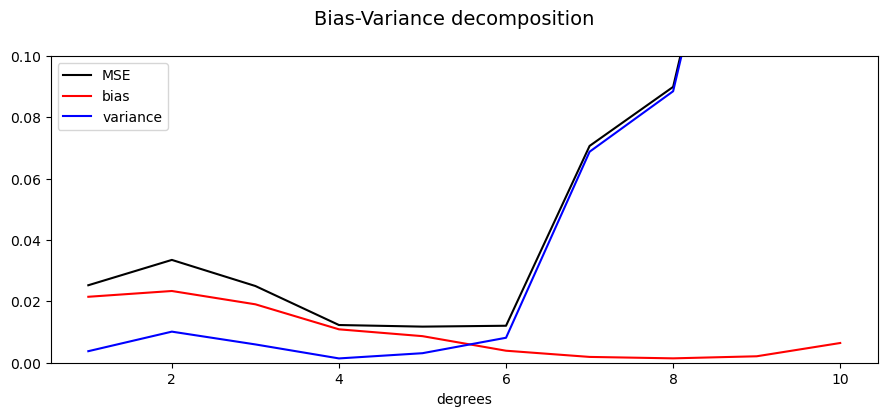

In [45]:
alpha = 0.2

# colors
colors = plt.cm.jet(np.linspace(0, 1, nb_bootstraps))

# figure
fig, ax = plt.subplots(1, 1, figsize=(9, 4), sharex=True)
fig.suptitle('Bias-Variance decomposition', fontsize=14)
fig.tight_layout(h_pad=2)

ax.plot(degrees, record['mean_mse_test'], '-k', label='MSE')
ax.plot(degrees, record['model_bias'], '-r', label='bias')
ax.plot(degrees, record['model_var'], '-b', label='variance')

ax.set_xlabel("degrees")
ax.legend(loc="upper left")

ax.set_ylim((0, 0.1))
plt.show()

### Plot results - OLS + Bootstrap

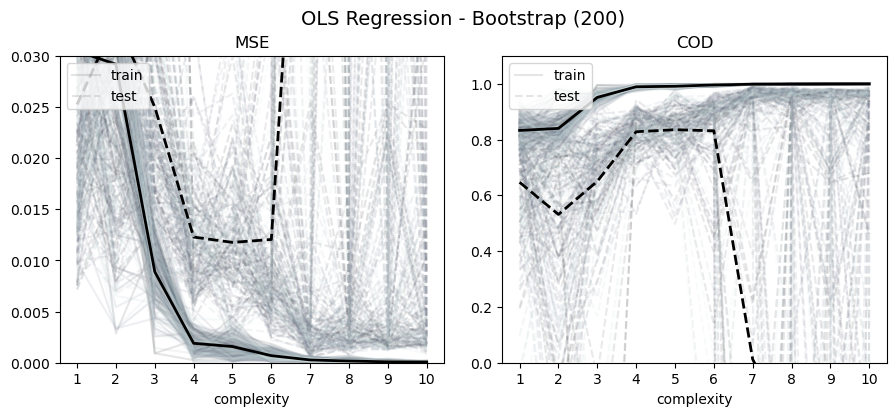

In [46]:
alpha = 0.1

# colors
#colors = plt.cm.jet(np.linspace(0, 1, nb_bootstraps))
colors = plt.cm.bone(np.linspace(0, 1, nb_bootstraps))

# figure
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle(f'OLS Regression - Bootstrap ({nb_bootstraps})', fontsize=14)
fig.tight_layout(h_pad=2)

for i in range(nb_bootstraps):
    axs[0].plot(degrees, record['mse_train'][:, i], '-', color=colors[i], alpha=alpha, label='train')
    axs[0].plot(degrees, record['mse_test'][:, i], '--', color=colors[i], alpha=alpha, label='test')
    axs[0].set_title(f"MSE")
    axs[0].set_xlabel('complexity')
    if i == 0: axs[0].legend(loc='upper left')
    axs[0].set_xticks(degrees)
    axs[0].grid()

    axs[1].plot(degrees, record['cod_train'][:, i], '-', color=colors[i], alpha=alpha, label='train')
    axs[1].plot(degrees, record['cod_test'][:, i], '--', color=colors[i], alpha=alpha, label='test')
    axs[1].set_title(f"COD")
    axs[1].set_xlabel('complexity')
    if i == 0: axs[1].legend(loc='upper left')
    axs[1].set_xticks(degrees)
    axs[1].grid()
    

# mean     
axs[0].plot(degrees, record['mean_mse_train'], '-k', alpha=1, linewidth=2, label='mean train')
axs[0].plot(degrees, record['mean_mse_test'], '--k', alpha=1, linewidth=2, label='mean test')
axs[1].plot(degrees, record['mean_cod_train'], '-k', alpha=1, linewidth=2, label='mean train')
axs[1].plot(degrees, record['mean_cod_test'], '--k', alpha=1, linewidth=2, label='mean test')
if i == (nb_bootstraps + 1): axs[0].legend(loc='upper left')
if i == (nb_bootstraps + 1): axs[1].legend(loc='upper left')

axs[0].set_ylim(0, 0.03)
axs[1].set_ylim(0, 1.1)

plt.show()

# (c) Cross-validation
---

SETTINGS

In [47]:
# data
N = 50
random_ax = True
noise_scale = 0.03
scaling = False
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale, scaling=scaling)

# model
nb_folds = 10
fold_source = 'manual'

# Design matrix
intercept = False
degrees = range(1, 10)

RUN

In [48]:
# prepare record
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': [],
          'mean_mse_train': [],
          'mean_cod_train': [],
          'mean_mse_test': [],
          'mean_cod_test': [],
          'model_bias': [],
          'model_var': []}

betas = {}

# run for all degrees
for deg in (bar := tqdm(degrees)):
    
    # define design matrix
    D = u.build_design_matrix(X=x, Y=y, degree=deg, intercept=intercept)
    
    # record
    mse_train_folds = []
    mse_test_folds = []
    cod_train_folds = []
    cod_test_folds = []
    betas_folds = []
    predictions_folds = []
    
    # build dataset folds
    fold_x, fold_z = u.cross_validation(X=D, Z=z, K=nb_folds, source=fold_source)
        
    
    # loop folds iterations
    for k in range(nb_folds):
        
        # OLS run
        beta, [mse_train, mse_test], [cod_train, cod_test], Z_pred_test = u.rOLS(dataset_x=fold_x[k], 
                                                                                 dataset_z=fold_z[k])
        
        # record fold results
        mse_train_folds += [mse_train]
        mse_test_folds += [mse_test]
        cod_train_folds += [cod_train]
        cod_test_folds += [cod_test]
        betas_folds += [beta]
        predictions_folds += [Z_pred_test.squeeze().tolist()]
        
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # record degree result
    record['mse_train'] += [mse_train_folds]
    record['cod_train'] += [cod_train_folds]
    record['mse_test'] += [mse_test_folds]
    record['cod_test'] += [cod_test_folds]
    
    # mean
    record['mean_mse_train'] += [np.mean(mse_train_folds)]
    record['mean_cod_train'] += [np.mean(cod_train_folds)]
    record['mean_mse_test'] += [np.mean(mse_test_folds)]
    record['mean_cod_test'] += [np.mean(cod_test_folds)]

    betas[deg] = [beta]

# covert records in arrays
record['mse_train'] = np.array(record['mse_train'])
record['cod_train'] = np.array(record['cod_train']) 
record['mse_test'] = np.array(record['mse_test']) 
record['cod_test'] = np.array(record['cod_test'])


print('.')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 110.66it/s]

.


### Plot results: OLS + K-Fold

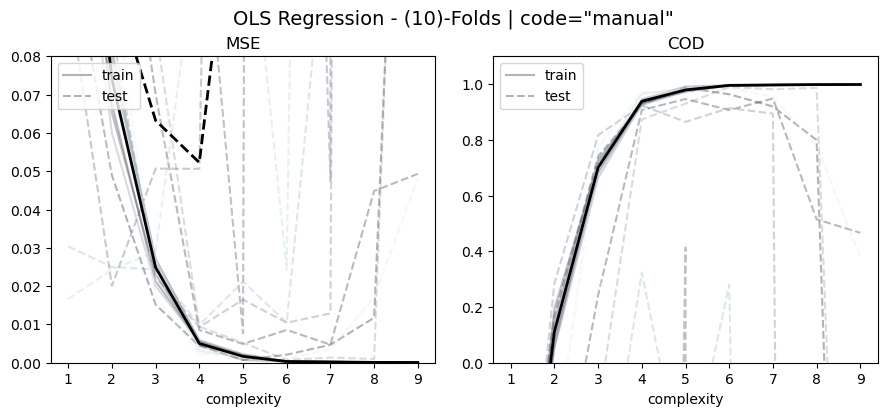

In [49]:
alpha = 0.3

# colors
colors = plt.cm.bone(np.linspace(0, 1, nb_folds))

# figure
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle(f'OLS Regression - ({nb_folds})-Folds | code="{fold_source}"', fontsize=14)
fig.tight_layout(h_pad=2)

for i in range(nb_folds):
    axs[0].plot(degrees, record['mse_train'][:, i], '-', color=colors[i], alpha=alpha, label='train')
    axs[0].plot(degrees, record['mse_test'][:, i], '--', color=colors[i], alpha=alpha, label='test')
    axs[0].set_title(f"MSE")
    axs[0].set_xlabel('complexity')
    if i == 0: axs[0].legend(loc='upper left')
    axs[0].set_xticks(degrees)
    axs[0].grid()

    axs[1].plot(degrees, record['cod_train'][:, i], '-', color=colors[i], alpha=alpha, label='train')
    axs[1].plot(degrees, record['cod_test'][:, i], '--', color=colors[i], alpha=alpha, label='test')
    axs[1].set_title(f"COD")
    axs[1].set_xlabel('complexity')
    if i == 0: axs[1].legend(loc='upper left')
    axs[1].set_xticks(degrees)
    axs[1].grid()
    

# mean     
axs[0].plot(degrees, record['mean_mse_train'], '-k', alpha=1, linewidth=2, label='mean train')
axs[0].plot(degrees, record['mean_mse_test'], '--k', alpha=1, linewidth=2, label='mean test')
axs[1].plot(degrees, record['mean_cod_train'], '-k', alpha=1, linewidth=2, label='mean train')
axs[1].plot(degrees, record['mean_cod_test'], '--k', alpha=1, linewidth=2, label='mean test')

axs[0].set_ylim(0, 0.08)
axs[1].set_ylim(0, 1.1)

plt.show()

---

# (d) Ridge regularization
---

### single run

SETTINGS

In [50]:
# data
N = 30
random_ax = True
noise_scale = 0.1
scaling = False
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale, scaling=scaling)

# model
nb_lambdas = 100
lambdas = np.logspace(-12, 7, nb_lambdas)
degrees = range(1, 11)
intercept = True

RUN

In [51]:
# prepare record
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': [],
          'mean_mse_train': [],
          'mean_cod_train': [],
          'mean_mse_test': [],
          'mean_cod_test': []}

betas = {}

# split data
x_train, x_test, y_train, y_test, Z_train, Z_test = train_test_split(x, y, z, test_size=0.20)

# iterate over different lambda values
for lmd in tqdm(lambdas):
    
    # record
    mse_train_lambdas = []
    mse_test_lambdas = []
    cod_train_lambdas = []
    cod_test_lambdas = []
    
    # run for all degrees
    for deg in degrees:

        # define design matrix
        #D = u.build_design_matrix(X=x, Y=y, degree=deg)

        # split data
        #X_train, X_test, Z_train, Z_test = train_test_split(D, z, test_size=0.20)

            
        # define design matrix
        D_train, D_test = u.build_design_matrix(X=x_train, Y=y_train, degree=deg, intercept=intercept), u.build_design_matrix(X=x_test, Y=y_test, 
                                                                                                         degree=deg, intercept=intercept)
        
        # OLS run
        beta, [mse_train, mse_test], [cod_train, cod_test], _ = u.rOLS(dataset_x=[D_train, D_test], 
                                                                       dataset_z=[Z_train, Z_test],
                                                                       ridge=True, 
                                                                       lambda_r=lmd)

        # record degree results
        mse_train_lambdas += [mse_train]
        mse_test_lambdas += [mse_test]
        cod_train_lambdas += [cod_train]
        cod_test_lambdas += [cod_test]

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # record lambda result
    record['mse_train'] += [mse_train_lambdas]
    record['cod_train'] += [cod_train_lambdas]
    record['mse_test'] += [mse_test_lambdas]
    record['cod_test'] += [cod_test_lambdas]

# covert records in arrays
record['mse_train'] = np.array(record['mse_train'])
record['cod_train'] = np.array(record['cod_train']) 
record['mse_test'] = np.array(record['mse_test']) 
record['cod_test'] = np.array(record['cod_test'])


print('.')

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 70.88it/s]

.


#### Plot results: OLS + Ridge

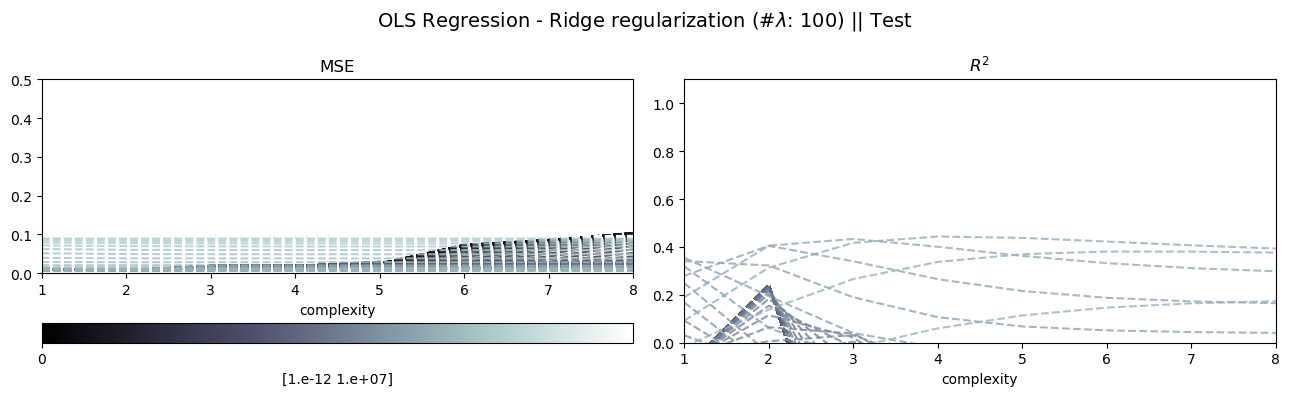

In [52]:
alpha = 0.8

# colors
colors = plt.cm.bone(np.linspace(0, 1, nb_lambdas))

# figure
fig, axs = plt.subplots(1, 2, figsize=(13, 4), sharex=True)
fig.suptitle(f'OLS Regression - Ridge regularization (#$\lambda$: {nb_lambdas}) || Test', fontsize=14)
fig.set_tight_layout({'h_pad': 5})

for i, l in enumerate(lambdas):
    #axs[0].plot(degrees, record['mse_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"Train $\lambda$={l:.1f}")
    axs[0].plot(degrees, record['mse_test'][i, :], '--', color=colors[i], label=f"Test $\lambda$={l:.1f}", alpha=alpha)
    axs[0].set_title(f"MSE")
    axs[0].set_xlabel('complexity')
    #axs[0].legend(loc='upper left', fontsize=7)
    axs[0].set_xticks(degrees)
    axs[0].grid()

    #axs[1].plot(degrees, record['cod_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"Train $\lambda$={l:.1f}")
    axs[1].plot(degrees, record['cod_test'][i, :], '--', color=colors[i], label=f"Test $\lambda$={l:.1f}", alpha=alpha)
    
    axs[1].set_title("$R^2$")
    axs[1].set_xlabel('complexity')
    #axs[1].legend(loc='upper left', fontsize=7)
    axs[1].set_xticks(degrees)
    axs[1].grid()

axs[0].set_ylim(0, 0.5)
axs[0].set_xlim(1, 8)

norm = plt_colors.Normalize(0, record['mse_test'].max())
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('bottom', size='10%', pad=0.5)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="bone"), ax=axs[0], cax=cax, orientation="horizontal", ticks=range(2), label=np.linspace(1e-12, 1e7, 2))

axs[1].set_xlim(1, 8)
axs[1].set_ylim(0, 1.1)

plt.show()

### averaged runs

SETTINGS

In [76]:
# data
N = 30
random_ax = True
noise_scale = 0.05
scaling = False
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale, scaling=scaling)

# model
n_iter = 50
nb_lambdas = 100
lambdas = np.logspace(-12, 7, nb_lambdas)
degrees = range(1, 11)
intercept = True

RUN

In [54]:
# prepare total record
tot_record = {'mse_train': [],
              'mse_test': [],
              'cod_train': [],
              'cod_test': []}


# split data
x_train, x_test, y_train, y_test, Z_train, Z_test = train_test_split(x, y, z, test_size=0.20)

for k in tqdm(range(n_iter)):

    # prepare record
    record = {'mse_train': [],
              'mse_test': [],
              'cod_train': [],
              'cod_test': []}

    betas = {}

    # iterate over different lambda values
    for lmd in lambdas:

        # record
        mse_train_lambdas = []
        mse_test_lambdas = []
        cod_train_lambdas = []
        cod_test_lambdas = []

        # run for all degrees
        for deg in degrees:

            # define design matrix
            D_train, D_test = u.build_design_matrix(X=x_train, Y=y_train, degree=deg, intercept=intercept), u.build_design_matrix(X=x_test, Y=y_test, 
                                                                                                             degree=deg, intercept=intercept)
            # OLS run
            beta, [mse_train, mse_test], [cod_train, cod_test], _ = u.rOLS(dataset_x=[D_train, D_test], 
                                                                           dataset_z=[Z_train, Z_test],
                                                                           ridge=True, 
                                                                           lambda_r=lmd)

            # record degree results
            mse_train_lambdas += [mse_train]
            mse_test_lambdas += [mse_test]
            cod_train_lambdas += [cod_train]
            cod_test_lambdas += [cod_test]

        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

        # record lambda result
        record['mse_train'] += [mse_train_lambdas]
        record['cod_train'] += [cod_train_lambdas]
        record['mse_test'] += [mse_test_lambdas]
        record['cod_test'] += [cod_test_lambdas]

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
    
    # record iteration results
    tot_record['mse_train'] += [record['mse_train']]
    tot_record['cod_train'] += [record['cod_train']]
    tot_record['mse_test'] += [record['mse_test']]
    tot_record['cod_test'] += [record['cod_test']]
    
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

# convert to arrays and average
tot_record['mse_train'] = np.array(tot_record['mse_train']).mean(axis=0)
tot_record['cod_train'] = np.array(tot_record['cod_train']).mean(axis=0) 
tot_record['mse_test'] = np.array(tot_record['mse_test']).mean(axis=0) 
tot_record['cod_test'] = np.array(tot_record['cod_test']).mean(axis=0)

print('.')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.41s/it]

.


#### Plot results

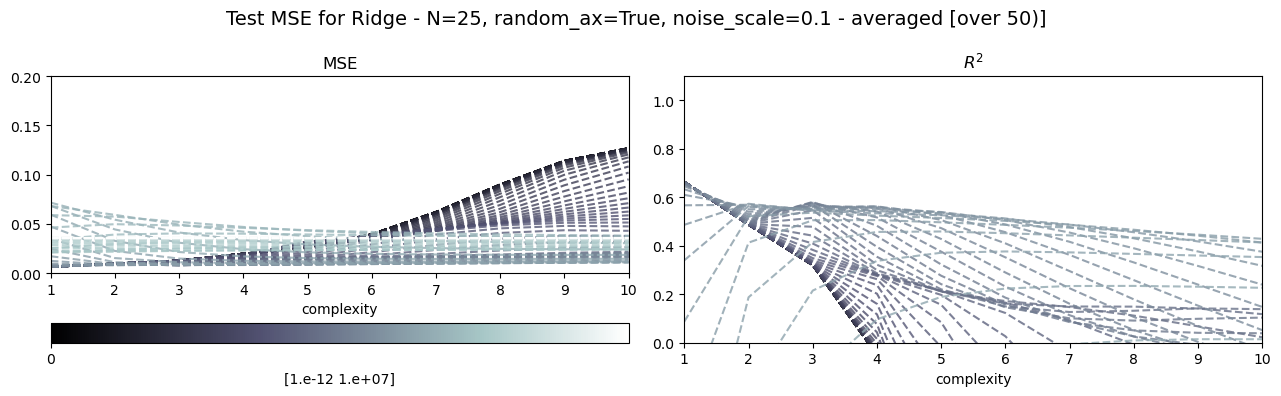

In [58]:
alpha = 0.8

# colors
colors = plt.cm.bone(np.linspace(0, 1, nb_lambdas))

# figure
fig, axs = plt.subplots(1, 2, figsize=(13, 4), sharex=True)
fig.suptitle(f'Test MSE for Ridge - {N=}, {random_ax=}, {noise_scale=} - averaged [over {n_iter})]', fontsize=14)
fig.set_tight_layout({'h_pad': 3})

for i, l in enumerate(lambdas):
    axs[0].plot(degrees, tot_record['mse_test'][i, :], '--', color=colors[i], alpha=alpha)
    axs[0].set_title(f"MSE")
    axs[0].set_xlabel('complexity')
    axs[0].set_xticks(degrees)
    axs[0].grid()

    axs[1].plot(degrees, tot_record['cod_test'][i, :], '--', color=colors[i], alpha=alpha)
    axs[1].set_title("$R^2$")
    axs[1].set_xlabel('complexity')
    axs[1].set_xticks(degrees)
    axs[1].grid()

axs[0].set_ylim(0., 0.2)
axs[0].set_xlim(1, 8)

axs[1].set_ylim(0, 1.1)
axs[1].set_xlim(1, 10)


norm = plt_colors.Normalize(0, tot_record['mse_test'].max())
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('bottom', size='10%', pad=0.5)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="bone"), ax=axs[0], cax=cax, orientation='horizontal', ticks=range(2), label=np.linspace(1e-12, 1e7, 2))

plt.show()

#### Heatmap

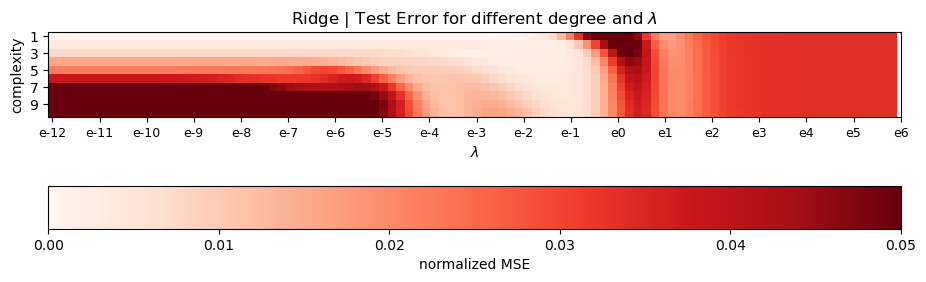

In [61]:
# clipping
data_to_plot = np.clip(tot_record['mse_test'], 0, 0.05).T

# plot
fig, ax = plt.subplots(figsize=(11, 6))
cmap = cm.get_cmap("Reds")
norm = plt_colors.Normalize(0, data_to_plot.max())

ax.set_title(f"Ridge | Test Error for different degree and $\lambda$")

ax.imshow(data_to_plot, cmap=cmap)

ax.set_ylabel('complexity')
ax.set_xlabel('$\lambda$')

# plot colorbar
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, location="bottom", label="normalized MSE")

#fig.colorbar(pos, ax)
lambdas_labels = [f"e{i}" for i in range(-12, 7)]
ax.set_xticks(np.linspace(0, nb_lambdas, len(lambdas_labels)))
ax.set_xticklabels(lambdas_labels, fontsize=9)
ax.set_yticks(range(0, len(degrees), 2))
ax.set_yticklabels(range(1, 11, 2))
plt.show()

## Ridge + Boostrap

SETTINGS - the rest is same as before

In [77]:
nb_bootstraps = 100

RUN

In [78]:
# general prepare record init
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': [],
          'mse': [],
          'bias': [],
          'var': []
         }

# split data
x_train, x_test, y_train, y_test, Z_train, Z_test = train_test_split(x, y, z, test_size=0.20)

# iterate over different lambda values
for lmd in (bar_lmd := tqdm(lambdas)):
    
    bar_lmd.set_description(f"lambda={lmd:.2f}")
    
    # record degree init
    mse_train_lambdas = []
    mse_test_lambdas = []
    cod_train_lambdas = []
    cod_test_lambdas = []
    
    model_mse = []
    model_bias = []
    model_var = []
    
    # run for all degrees
    for deg in degrees:
        
        # define design matrix
        #D = u.build_design_matrix(X=x, Y=y, degree=deg)

        # split data
        #X_train, X_test, Z_train, Z_test = train_test_split(D, z, test_size=0.20)

        
        # define design matrix
        D_train, D_test = u.build_design_matrix(X=x_train, Y=y_train, degree=deg, intercept=intercept), u.build_design_matrix(X=x_test, Y=y_test, 
                                                                                                         degree=deg, intercept=intercept)
        #
        len_train = len(D_train)
        list_len_train = list(range(len_train))

        # record bootstrap init
        mse_train_boot = []
        mse_test_boot = []
        cod_train_boot = []
        cod_test_boot = []
        betas_boot = []
        predictions_boot = []

        # for bias-variance calculation
        pred_boots = np.empty((Z_test.shape[0], nb_bootstraps))
        
        # loop bootstrap iterations
        for i_boot in range(nb_bootstraps):

            # define new sampled training set
            indexes = np.random.choice(list_len_train, p=np.ones(len_train)/len_train, \
                                       replace=True, size=len_train)
            D_train_resampled = D_train[indexes]
            Z_train_resampled = Z_train[indexes]

            # train OLS with resampled data
            _, [mse_train, mse_test], [cod_train, cod_test], Z_pred_test = u.rOLS(dataset_x=[D_train_resampled, D_test], 
                                                                        dataset_z=[Z_train_resampled, Z_test],
                                                                        ridge=True,
                                                                        lambda_r=lmd)


            # record bootstrap results
            mse_train_boot += [mse_train]
            mse_test_boot += [mse_test]
            cod_train_boot += [cod_train]
            cod_test_boot += [cod_test]
            
            pred_boots[:, i_boot] = Z_pred_test.flatten()

        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #    
    
        # record degree results | average over bootstrap sessions
        mse_train_lambdas += [np.mean(mse_train_boot)]
        mse_test_lambdas += [np.mean(mse_test_boot)]
        cod_train_lambdas += [np.mean(cod_train_boot)]
        cod_test_lambdas += [np.mean(cod_test_boot)]
        

        # bias-variance | degree
        model_mse += [np.mean( np.mean((Z_test - pred_boots)**2, axis=1, keepdims=True))]
        model_bias += [np.mean( (Z_test - np.mean(pred_boots, axis=1, keepdims=True))**2)]
        model_var += [np.mean( np.var(pred_boots, axis=1, keepdims=True))]

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # record lambda result
    record['mse_train'] += [mse_train_lambdas]
    record['cod_train'] += [cod_train_lambdas]
    record['mse_test'] += [mse_test_lambdas]
    record['cod_test'] += [cod_test_lambdas]
    
    # bias-variance | lambda
    record['mse'] += [model_mse]
    record['bias'] += [model_bias]
    record['var'] += [model_var]

# covert records in arrays
record['mse_train'] = np.array(record['mse_train'])
record['cod_train'] = np.array(record['cod_train']) 
record['mse_test'] = np.array(record['mse_test']) 
record['cod_test'] = np.array(record['cod_test'])
record['mse'] = np.array(record['mse'])
record['bias'] = np.array(record['bias'])
record['var'] = np.array(record['var'])


print('.')

lambda=10000000.00: 100%|███████████████████████████████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]

.


### Plot results: OLS + Ridge + Bootstrap

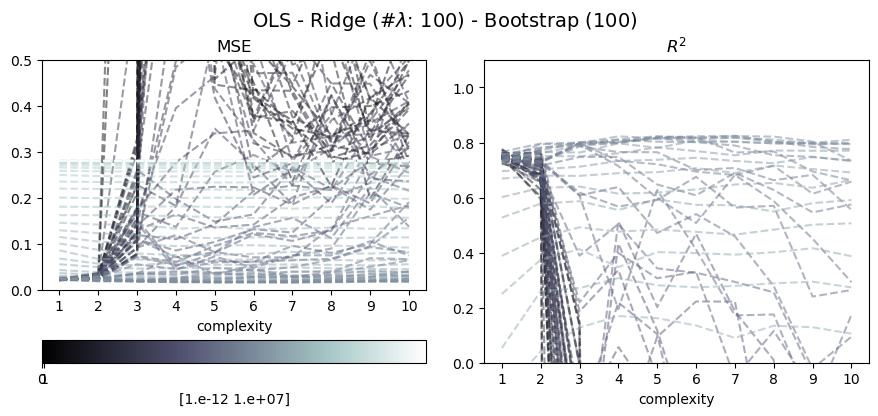

In [79]:
alpha = 0.5

# colors
colors = plt.cm.bone(np.linspace(0, 1, nb_lambdas))

# figure
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle(f'OLS - Ridge (#$\lambda$: {nb_lambdas}) - Bootstrap ({nb_bootstraps})', fontsize=14)
fig.tight_layout(h_pad=2)

for i, l in enumerate(lambdas):
    #axs[0].plot(degrees, record['mse_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"$\lambda$={l:.1f}")
    axs[0].plot(degrees, record['mse_test'][i, :], '--', color=colors[i], alpha=alpha)
    axs[0].set_title(f"MSE")
    axs[0].set_xlabel('complexity')
    #axs[0].legend(loc='upper left', fontsize=7)
    axs[0].set_xticks(degrees)
    axs[0].grid()

    #axs[1].plot(degrees, record['cod_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"$\lambda$={l:.1f}")
    axs[1].plot(degrees, record['cod_test'][i, :], '--', color=colors[i], alpha=alpha)
    
    axs[1].set_title("$R^2$")
    axs[1].set_xlabel('complexity')
    #axs[1].legend(loc='upper left', fontsize=7)
    axs[1].set_xticks(degrees)
    axs[1].grid()
    

norm = plt_colors.Normalize(0, record['mse_test'].max())
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('bottom', size='10%', pad=0.5)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="bone"), ax=axs[0], cax=cax, orientation='horizontal', ticks=range(2), label=np.linspace(1e-12, 1e7, 2))


axs[0].set_ylim(0, 0.5)
axs[1].set_ylim(0, 1.1)
plt.show()

### Heatmap

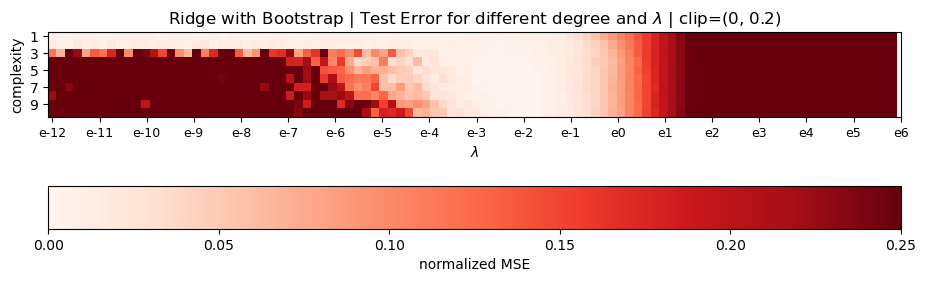

In [80]:
data_to_plot = np.clip(record['mse_test'], 0, 0.25).T

fig, ax = plt.subplots(figsize=(11, 6))
cmap = cm.get_cmap("Reds")
norm = plt_colors.Normalize(0, data_to_plot.max())

ax.set_title(f"Ridge with Bootstrap | Test Error for different degree and $\lambda$ | clip=(0, 0.2)")

ax.imshow(data_to_plot, cmap=cmap)

ax.set_ylabel('complexity')
ax.set_xlabel('$\lambda$')

# plot colorbar
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', label="normalized MSE")

#fig.colorbar(pos, ax)
lambdas_labels = [f"e{i}" for i in range(-12, 7)]
ax.set_xticks(np.linspace(0, nb_lambdas, len(lambdas_labels)))
ax.set_xticklabels(lambdas_labels, fontsize=9)
ax.set_yticks(range(0, len(degrees), 2))
ax.set_yticklabels(range(1, 11, 2))
plt.show()

### Bias-variance

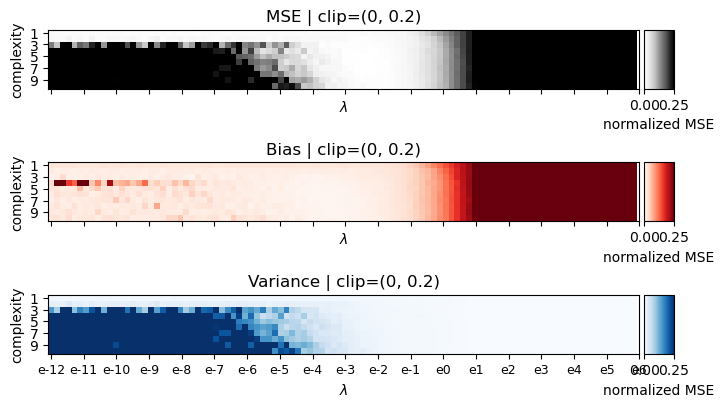

In [81]:
fig, axs = plt.subplots(3, 1, figsize=(10, 4), sharex=True)
fig.set_tight_layout({'h_pad': 2})

### MSE ###

clip_lim = 0.2

# clip data
mse_clip = np.clip(record['mse'], 0, clip_lim).T

# plot
axs[0].imshow(mse_clip, cmap="Greys")

# axis labels
axs[0].set_ylabel('complexity')
axs[0].set_xlabel('$\lambda$')
axs[0].set_title('MSE | clip=(0, 0.2)')

lambdas_labels = [f"e{i}" for i in range(-12, 7)]
axs[0].set_xticks(np.linspace(0, nb_lambdas, len(lambdas_labels)))
axs[0].set_xticklabels(lambdas_labels, fontsize=9)
axs[0].set_yticks(range(0, len(degrees), 2))
axs[0].set_yticklabels(range(1, 11, 2))

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="Greys"), ax=axs[0], cax=cax, orientation='horizontal', label="normalized MSE")
    
### BIAS ###

bias_clip = np.clip(record['bias'], 0, clip_lim).T

# plot
axs[1].imshow(bias_clip, cmap="Reds")

# axis labels
axs[1].set_ylabel('complexity')
axs[1].set_xlabel('$\lambda$')
axs[1].set_title('Bias | clip=(0, 0.2)')

lambdas_labels = [f"e{i}" for i in range(-12, 7)]
axs[1].set_xticks(np.linspace(0, nb_lambdas, len(lambdas_labels)))
axs[1].set_xticklabels(lambdas_labels, fontsize=9)
axs[1].set_yticks(range(0, len(degrees), 2))
axs[1].set_yticklabels(range(1, 11, 2))

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="Reds"), ax=axs[1], cax=cax, orientation='horizontal', label="normalized MSE")

### VAR ###

var_clip = np.clip(record['var'], 0, clip_lim).T

# plot
axs[2].imshow(var_clip, cmap="Blues")

# axis labels
axs[2].set_ylabel('complexity')
axs[2].set_xlabel('$\lambda$')
axs[2].set_title('Variance | clip=(0, 0.2)')

lambdas_labels = [f"e{i}" for i in range(-12, 7)]
axs[2].set_xticks(np.linspace(0, nb_lambdas, len(lambdas_labels)))
axs[2].set_xticklabels(lambdas_labels, fontsize=9)
axs[2].set_yticks(range(0, len(degrees), 2))
axs[2].set_yticklabels(range(1, 11, 2))

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="Blues"), ax=axs[2], cax=cax, orientation='horizontal', label="normalized MSE")

plt.show()

## Ridge + Cross-validation

SETTINGS

In [82]:
# data
N = 30
random_ax = True
noise_scale = 0.1
scaling = False
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale, scaling=scaling)

# model
n_iter = 20
nb_lambdas = 100
lambdas = np.logspace(-12, 7, nb_lambdas)
degrees = range(1, 11)
intercept = True

#
nb_folds = 10
fold_source = "manual"

RUN

In [83]:
# general prepare record init
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': []}

# iterate over different lambda values
for lmd in (bar_lmd := tqdm(lambdas)):
    
    bar_lmd.set_description(f"lambda={lmd:.2f}")
    
    # record degree init
    mse_train_lambdas = []
    mse_test_lambdas = []
    cod_train_lambdas = []
    cod_test_lambdas = []
    
    # run for all degrees
    for deg in degrees:
        
        # define design matrix
        D = u.build_design_matrix(X=x, Y=y, degree=deg, intercept=intercept)
        
        # record KFold init
        mse_train_folds = []
        mse_test_folds = []
        cod_train_folds = []
        cod_test_folds = []
        betas_folds = []
        predictions_folds = []

        
        # build dataset folds
        fold_x, fold_z = u.cross_validation(X=D, Z=z, K=nb_folds, source=fold_source)

        # loop folds iterations
        for k in range(nb_folds):

            # OLS run
            _, [mse_train, mse_test], [cod_train, cod_test], _ = u.rOLS(dataset_x=fold_x[k], 
                                                                        dataset_z=fold_z[k],
                                                                        ridge=True,
                                                                        lambda_r=lmd)

            # record fold results
            mse_train_folds += [mse_train]
            mse_test_folds += [mse_test]
            cod_train_folds += [cod_train]
            cod_test_folds += [cod_test]
        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #    
    
        # record degree results | average over bootstrap sessions
        mse_train_lambdas += [np.mean(mse_train_folds)]
        mse_test_lambdas += [np.mean(mse_test_folds)]
        cod_train_lambdas += [np.mean(cod_train_folds)]
        cod_test_lambdas += [np.mean(cod_test_folds)]

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # record lambda result
    record['mse_train'] += [mse_train_lambdas]
    record['cod_train'] += [cod_train_lambdas]
    record['mse_test'] += [mse_test_lambdas]
    record['cod_test'] += [cod_test_lambdas]

# covert records in arrays
record['mse_train'] = np.array(record['mse_train'])
record['cod_train'] = np.array(record['cod_train']) 
record['mse_test'] = np.array(record['mse_test']) 
record['cod_test'] = np.array(record['cod_test'])


print('.')

lambda=10000000.00: 100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.98it/s]

.


### Plot results: OLS + Ridge + Cross-validation

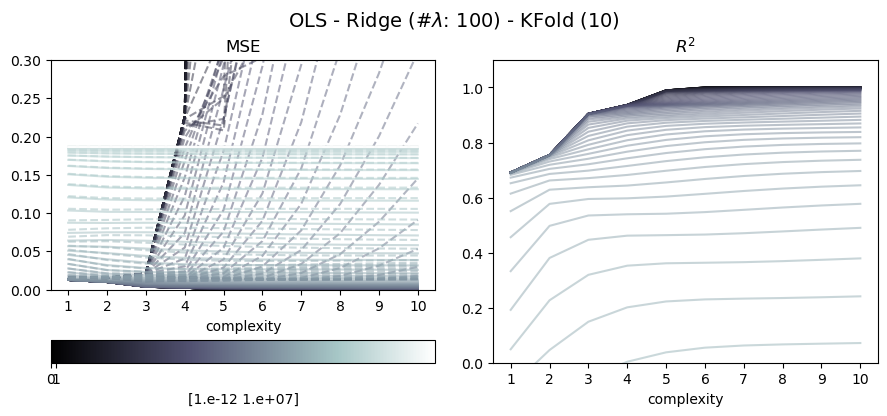

In [85]:
alpha = 0.5

# colors
colors = plt.cm.bone(np.linspace(0, 1, nb_lambdas))

# figure
fig_cv, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig_cv.suptitle(f'OLS - Ridge (#$\lambda$: {nb_lambdas}) - KFold ({nb_folds})', fontsize=14)
fig_cv.tight_layout(h_pad=2)

#
for i, l in enumerate(lambdas):
    axs[0].plot(degrees, record['mse_train'][i, :], '-', color=colors[i], alpha=alpha)
    axs[0].plot(degrees, record['mse_test'][i, :], '--', color=colors[i], alpha=alpha)
    axs[0].set_title(f"MSE")
    axs[0].set_xlabel('complexity')
    #axs[0].legend(loc='upper left', fontsize=7)
    axs[0].set_xticks(degrees)
    axs[0].grid()

    axs[1].plot(degrees, record['cod_train'][i, :], '-', color=colors[i], alpha=alpha)
    axs[1].plot(degrees, record['cod_test'][i, :], '--', color=colors[i], alpha=alpha)
    
    axs[1].set_title("$R^2$")
    axs[1].set_xlabel('complexity')
    #axs[1].legend(loc='upper left', fontsize=7)
    axs[1].set_xticks(degrees)
    axs[1].grid()
    

norm = plt_colors.Normalize(0, record['mse_test'].max())
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('bottom', size='10%', pad=0.5)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="bone"), ax=axs[0], cax=cax, orientation='horizontal', ticks=range(2), label=np.linspace(1e-12, 1e7, 2))


axs[0].set_ylim(0, 0.3)
axs[1].set_ylim(0, 1.1)
plt.show()

### Heatmap

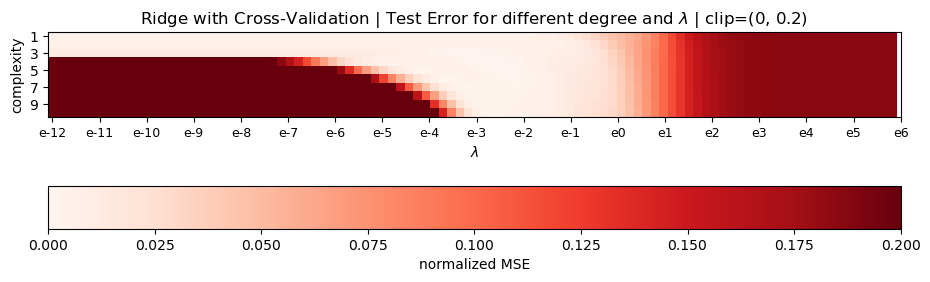

In [86]:
data_to_plot = np.clip(record['mse_test'], 0, 0.2).T

fig_cv, ax = plt.subplots(figsize=(11, 6))
cmap = cm.get_cmap("Reds")
norm = plt_colors.Normalize(0, data_to_plot.max())

ax.set_title(f"Ridge with Cross-Validation | Test Error for different degree and $\lambda$ | clip=(0, 0.2)")

ax.imshow(data_to_plot, cmap=cmap)

ax.set_ylabel('complexity')
ax.set_xlabel('$\lambda$')

# plot colorbar
fig_cv.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', label="normalized MSE")

#fig.colorbar(pos, ax)
lambdas_labels = [f"e{i}" for i in range(-12, 7)]
ax.set_xticks(np.linspace(0, nb_lambdas, len(lambdas_labels)))
ax.set_xticklabels(lambdas_labels, fontsize=9)
ax.set_yticks(range(0, len(degrees), 2))
ax.set_yticklabels(range(1, 11, 2))
plt.show()

# (e) Lasso regularization
---

SETTINGS

In [124]:
# data
N = 30
random_ax = True
noise_scale = 0.1
scaling = False
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale, scaling=scaling)

# model
nb_lambdas = 100
lambdas = np.logspace(-12, 7, nb_lambdas)
degrees = range(1, 11)
intercept = True

### single run

In [125]:
# prepare record
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': [],
          'mean_mse_train': [],
          'mean_cod_train': [],
          'mean_mse_test': [],
          'mean_cod_test': []}

betas = {}

# split data
x_train, x_test, y_train, y_test, Z_train, Z_test = train_test_split(x, y, z, test_size=0.20)

# iterate over different lambda values
for lmd in tqdm(lambdas):
    
    # record
    mse_train_lambdas = []
    mse_test_lambdas = []
    cod_train_lambdas = []
    cod_test_lambdas = []
    
    # run for all degrees
    for deg in degrees:

        # define design matrix
        #D = u.build_design_matrix(X=x, Y=y, degree=deg)

        # split data
        #X_train, X_test, Z_train, Z_test = train_test_split(D, z, test_size=0.20)

        # define design matrix
        D_train, D_test = u.build_design_matrix(X=x_train, Y=y_train, degree=deg, intercept=intercept), u.build_design_matrix(X=x_test, Y=y_test, 
                                                                                                         degree=deg, intercept=intercept)
        # OLS run
        beta, [mse_train, mse_test], [cod_train, cod_test], _ = u.rOLS(dataset_x=[D_train, D_test], 
                                                                       dataset_z=[Z_train, Z_test],
                                                                       lasso=True, 
                                                                       lambda_r=lmd)

        # record degree results
        mse_train_lambdas += [mse_train]
        mse_test_lambdas += [mse_test]
        cod_train_lambdas += [cod_train]
        cod_test_lambdas += [cod_test]

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # record lambda result
    record['mse_train'] += [mse_train_lambdas]
    record['cod_train'] += [cod_train_lambdas]
    record['mse_test'] += [mse_test_lambdas]
    record['cod_test'] += [cod_test_lambdas]

# covert records in arrays
record['mse_train'] = np.array(record['mse_train'])
record['cod_train'] = np.array(record['cod_train']) 
record['mse_test'] = np.array(record['mse_test']) 
record['cod_test'] = np.array(record['cod_test'])


print('.')

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.08it/s]

.


#### Plot results

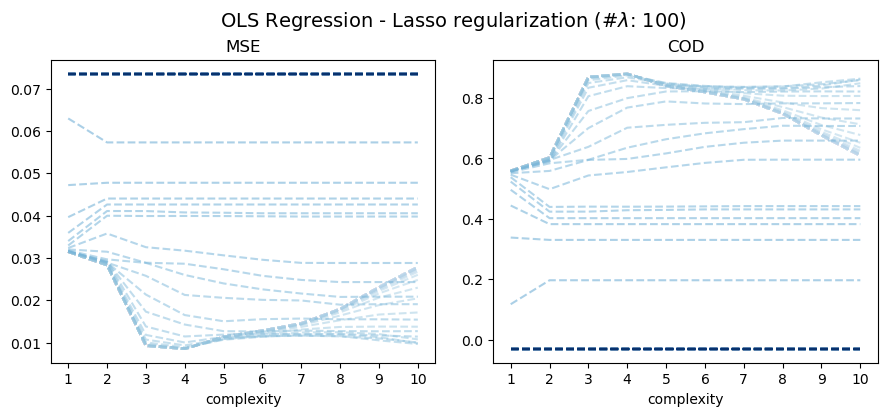

In [126]:
alpha = 0.5

# colors
colors = plt.cm.Blues(np.linspace(0, 1, nb_lambdas))

# figure
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
fig.suptitle(f'OLS Regression - Lasso regularization (#$\lambda$: {nb_lambdas})', fontsize=14)
fig.tight_layout(h_pad=2)

for i, l in enumerate(lambdas):
    #axs[0].plot(degrees, record['mse_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"$\lambda$={l:.1f}")
    axs[0].plot(degrees, record['mse_test'][i, :], '--', color=colors[i], alpha=alpha)
    axs[0].set_title(f"MSE")
    axs[0].set_xlabel('complexity')
    #axs[0].legend(loc='upper left', fontsize=7)
    axs[0].set_xticks(degrees)
    axs[0].grid()

    #axs[1].plot(degrees, record['cod_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"$\lambda$={l:.1f}")
    axs[1].plot(degrees, record['cod_test'][i, :], '--', color=colors[i], alpha=alpha)
    
    axs[1].set_title(f"COD")
    axs[1].set_xlabel('complexity')
    #axs[1].legend(loc='upper left', fontsize=7)
    axs[1].set_xticks(degrees)
    axs[1].grid()


plt.show()

### averaged runs

SETTINGS

In [114]:
N = 30
random_ax = True
noise_scale = 0.1
scaling = False
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale)

n_iter = 20
nb_lambdas = 100
lambdas = np.logspace(-12, 7, nb_lambdas)
degrees = range(1, 11)
intercept = True

RUN

In [115]:
# prepare total record
tot_record = {'mse_train': [],
              'mse_test': [],
              'cod_train': [],
              'cod_test': []}

# split data
x_train, x_test, y_train, y_test, Z_train, Z_test = train_test_split(x, y, z, test_size=0.20)

for k in tqdm(range(n_iter)):

    # prepare record
    record = {'mse_train': [],
              'mse_test': [],
              'cod_train': [],
              'cod_test': []}

    betas = {}

    # iterate over different lambda values
    for lmd in lambdas:

        # record
        mse_train_lambdas = []
        mse_test_lambdas = []
        cod_train_lambdas = []
        cod_test_lambdas = []

        # run for all degrees
        for deg in degrees:

            # define design matrix
            #D = u.build_design_matrix(X=x, Y=y, degree=deg)
            # define design matrix
            D_train, D_test = u.build_design_matrix(X=x_train, Y=y_train, degree=deg, intercept=intercept), u.build_design_matrix(X=x_test, Y=y_test, 
                                                                                                             degree=deg, intercept=intercept)
            # split data
            #X_train, X_test, Z_train, Z_test = train_test_split(D, z, test_size=0.20)

            # OLS run
            beta, [mse_train, mse_test], [cod_train, cod_test], _ = u.rOLS(dataset_x=[D_train, D_test], 
                                                                           dataset_z=[Z_train, Z_test],
                                                                           lasso=True, 
                                                                           lambda_r=lmd)

            # record degree results
            mse_train_lambdas += [mse_train]
            mse_test_lambdas += [mse_test]
            cod_train_lambdas += [cod_train]
            cod_test_lambdas += [cod_test]

        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

        # record lambda result
        record['mse_train'] += [mse_train_lambdas]
        record['cod_train'] += [cod_train_lambdas]
        record['mse_test'] += [mse_test_lambdas]
        record['cod_test'] += [cod_test_lambdas]

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
    
    # record iteration results
    
    tot_record['mse_train'] += [record['mse_train']]
    tot_record['cod_train'] += [record['cod_train']]
    tot_record['mse_test'] += [record['mse_test']]
    tot_record['cod_test'] += [record['cod_test']]
    
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

# convert to arrays and average
tot_record['mse_train'] = np.array(tot_record['mse_train']).mean(axis=0)
tot_record['cod_train'] = np.array(tot_record['cod_train']).mean(axis=0) 
tot_record['mse_test'] = np.array(tot_record['mse_test']).mean(axis=0) 
tot_record['cod_test'] = np.array(tot_record['cod_test']).mean(axis=0)

print('.')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:37<00:00,  1.88s/it]

.


#### Plot results

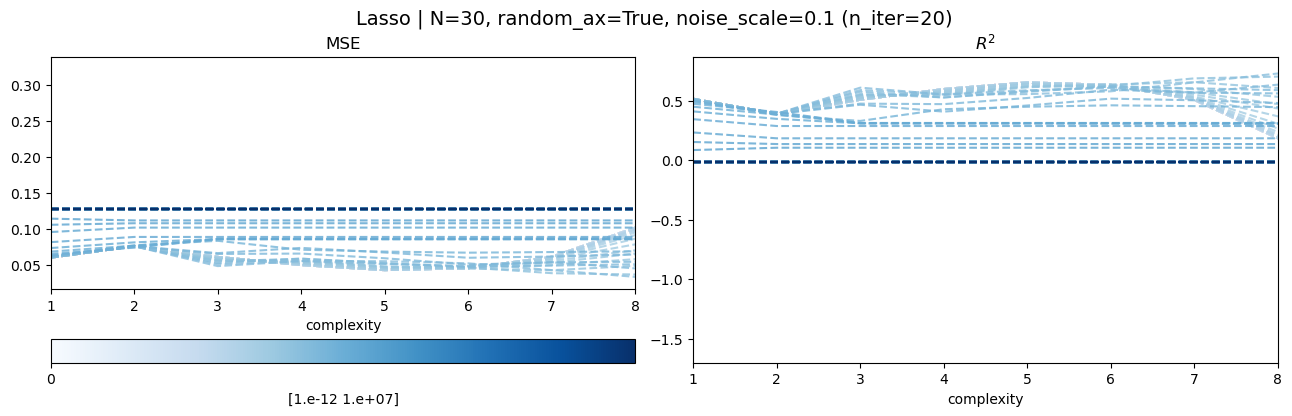

In [116]:
alpha = 0.8

# colors
colors = plt.cm.Blues(np.linspace(0, 1, nb_lambdas))

# figure
fig, axs = plt.subplots(1, 2, figsize=(13, 4), sharex=True)
fig.suptitle(f'Lasso | {N=}, {random_ax=}, {noise_scale=} ({n_iter=})', fontsize=14)
fig.tight_layout(h_pad=2)

for i, l in enumerate(lambdas):
    #axs[0].plot(degrees, tot_record['mse_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"Train $\lambda$={l:.1f}")
    axs[0].plot(degrees, tot_record['mse_test'][i, :], '--', color=colors[i], label=f"Test $\lambda$={l:.1f}", alpha=alpha)
    axs[0].set_title(f"MSE")
    axs[0].set_xlabel('complexity')
    #axs[0].legend(loc='upper left', fontsize=7)
    axs[0].set_xticks(degrees)
    axs[0].grid()

    #axs[1].plot(degrees, tot_record['cod_train'][i, :], '-', color=colors[i], alpha=alpha, label=f"Train $\lambda$={l:.1f}")
    axs[1].plot(degrees, tot_record['cod_test'][i, :], '--', color=colors[i], label=f"Test $\lambda$={l:.1f}", alpha=alpha)
    
    axs[1].set_title("$R^2$")
    axs[1].set_xlabel('complexity')
    #axs[1].legend(loc='upper left', fontsize=7)
    axs[1].set_xticks(degrees)
    axs[1].grid()

#axs[0].set_ylim(0.2, 0.3)
#axs[1].set_ylim(0, 1.1)

axs[0].set_xlim(1, 8)
axs[1].set_xlim(1, 8)

norm = plt_colors.Normalize(0, tot_record['mse_test'].max())
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('bottom', size='10%', pad=0.5)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap="Blues"), ax=axs[0], cax=cax, orientation='horizontal', ticks=range(2), label=np.linspace(1e-12, 1e7, 2))

plt.show()

#### Heatmap

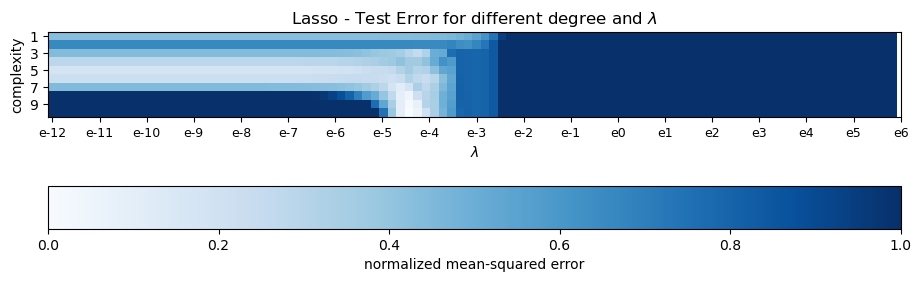

In [117]:
data_to_plot = np.clip(tot_record['mse_test'], 0, 0.1).T

fig, ax = plt.subplots(figsize=(11, 6))
cmap = cm.get_cmap("Blues")
norm = plt_colors.Normalize(0, data_to_plot.max())

ax.set_title(f"Lasso - Test Error for different degree and $\lambda$")

ax.imshow(data_to_plot, cmap=cmap)

ax.set_ylabel('complexity')
ax.set_xlabel('$\lambda$')

# plot colorbar
fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax, orientation='horizontal', label="normalized mean-squared error")

#fig.colorbar(pos, ax)
lambdas_labels = [f"e{i}" for i in range(-12, 7)]
ax.set_xticks(np.linspace(0, nb_lambdas, len(lambdas_labels)))
ax.set_xticklabels(lambdas_labels, fontsize=9)
ax.set_yticks(range(0, len(degrees), 2))
ax.set_yticklabels(range(1, 11, 2))
plt.show()

## Lasso + Bootstrap

DATA

In [132]:
# data
N = 30
random_ax = True
noise_scale = 0.1
scaling = False
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale, scaling=scaling)

# model
nb_lambdas = 100
lambdas = np.logspace(-12, 7, nb_lambdas)
degrees = range(1, 11)
intercept = True

nb_bootstraps = 100

RUN

In [133]:
# general prepare record init
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': [],
          'mse': [],
          'bias': [],
          'var': []
         }

# split data
x_train, x_test, y_train, y_test, Z_train, Z_test = train_test_split(x, y, z, test_size=0.20)

# iterate over different lambda values
for lmd in (bar_lmd := tqdm(lambdas)):
    
    bar_lmd.set_description(f"lambda={lmd:.12f}")
    
    # record degree init
    mse_train_lambdas = []
    mse_test_lambdas = []
    cod_train_lambdas = []
    cod_test_lambdas = []
    
    model_mse = []
    model_bias = []
    model_var = []
    
    # run for all degrees
    for deg in degrees:
        
        # define design matrix
        D_train, D_test = u.build_design_matrix(X=x_train, Y=y_train, degree=deg, intercept=intercept), u.build_design_matrix(X=x_test, Y=y_test, 
                                                                                                             degree=deg, intercept=intercept)


        #
        len_train = len(D_train)
        list_len_train = list(range(len_train))

        # record bootstrap init
        mse_train_boot = []
        mse_test_boot = []
        cod_train_boot = []
        cod_test_boot = []
        betas_boot = []
        predictions_boot = []

        # for bias-variance calculation
        pred_boots = np.empty((Z_test.shape[0], nb_bootstraps))
        
        # loop bootstrap iterations
        for i_boot in range(nb_bootstraps):

            # define new sampled training set
            indexes = np.random.choice(list_len_train, p=np.ones(len_train)/len_train, \
                                       replace=True, size=len_train)
            D_train_resampled = D_train[indexes]
            Z_train_resampled = Z_train[indexes]

            # train OLS with resampled data
            _, [mse_train, mse_test], [cod_train, cod_test], Z_pred_test = u.rOLS(dataset_x=[D_train_resampled, D_test], 
                                                                        dataset_z=[Z_train_resampled, Z_test],
                                                                        ridge=False,
                                                                        lasso=True,
                                                                        lambda_r=lmd)


            # record bootstrap results
            mse_train_boot += [mse_train]
            mse_test_boot += [mse_test]
            cod_train_boot += [cod_train]
            cod_test_boot += [cod_test]
            
            pred_boots[:, i_boot] = Z_pred_test.flatten()

        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #    
    
        # record degree results | average over bootstrap sessions
        mse_train_lambdas += [np.mean(mse_train_boot)]
        mse_test_lambdas += [np.mean(mse_test_boot)]
        cod_train_lambdas += [np.mean(cod_train_boot)]
        cod_test_lambdas += [np.mean(cod_test_boot)]
        

        # bias-variance | degree
        model_mse += [np.mean( np.mean((Z_test - pred_boots)**2, axis=1, keepdims=True))]
        model_bias += [np.mean( (Z_test - np.mean(pred_boots, axis=1, keepdims=True))**2)]
        model_var += [np.mean( np.var(pred_boots, axis=1, keepdims=True))]

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # record lambda result
    record['mse_train'] += [mse_train_lambdas]
    record['cod_train'] += [cod_train_lambdas]
    record['mse_test'] += [mse_test_lambdas]
    record['cod_test'] += [cod_test_lambdas]
    
    # bias-variance | lambda
    record['mse'] += [model_mse]
    record['bias'] += [model_bias]
    record['var'] += [model_var]

# covert records in arrays
record['mse_train'] = np.array(record['mse_train'])
record['cod_train'] = np.array(record['cod_train']) 
record['mse_test'] = np.array(record['mse_test']) 
record['cod_test'] = np.array(record['cod_test'])
record['mse'] = np.array(record['mse'])
record['bias'] = np.array(record['bias'])
record['var'] = np.array(record['var'])


print('.')

lambda=10000000.000000000000: 100%|█████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]

.


### Heatmap

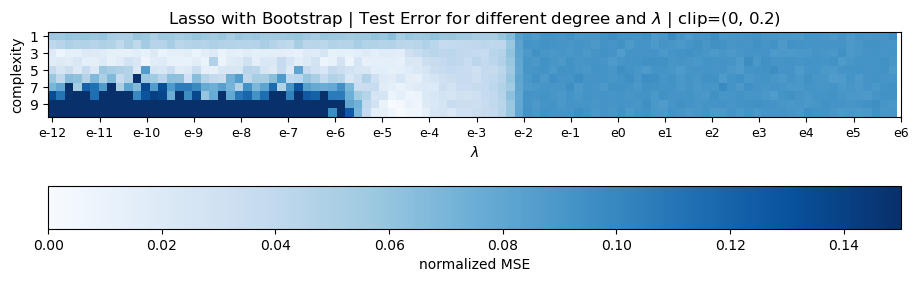

In [141]:
data_to_plot = np.clip(record['mse'], 0, 0.15).T

fig, ax = plt.subplots(figsize=(11, 6))
cmap = cm.get_cmap("Blues")
norm = plt_colors.Normalize(0, data_to_plot.max())

ax.set_title(f"Lasso with Bootstrap | Test Error for different degree and $\lambda$ | clip=(0, 0.2)")

ax.imshow(data_to_plot, cmap=cmap)

ax.set_ylabel('complexity')
ax.set_xlabel('$\lambda$')

# plot colorbar
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', label="normalized MSE")

#fig.colorbar(pos, ax)
lambdas_labels = [f"e{i}" for i in range(-12, 7)]
ax.set_xticks(np.linspace(0, nb_lambdas, len(lambdas_labels)))
ax.set_xticklabels(lambdas_labels, fontsize=9)
ax.set_yticks(range(0, len(degrees), 2))
ax.set_yticklabels(range(1, 11, 2))
plt.show()

### Bias-variance decomposition

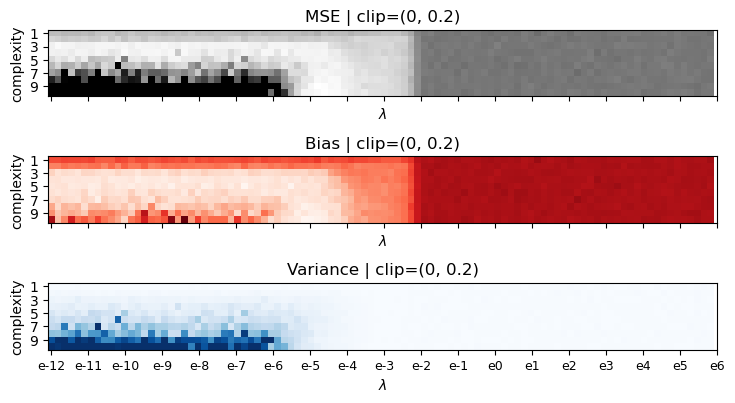

In [136]:
fig, axs = plt.subplots(3, 1, figsize=(10, 4), sharex=True)
fig.set_tight_layout({'h_pad': 2})

### MSE ###

clip_cut = 0.15

# clip data
mse_clip = np.clip(record['mse'], 0, clip_cut).T

# plot
axs[0].imshow(mse_clip, cmap="Greys")

# axis labels
axs[0].set_ylabel('complexity')
axs[0].set_xlabel('$\lambda$')
axs[0].set_title('MSE | clip=(0, 0.2)')

lambdas_labels = [f"e{i}" for i in range(-12, 7)]
axs[0].set_xticks(np.linspace(0, nb_lambdas, len(lambdas_labels)))
axs[0].set_xticklabels(lambdas_labels, fontsize=9)
axs[0].set_yticks(range(0, len(degrees), 2))
axs[0].set_yticklabels(range(1, 11, 2))
    
### BIAS ###

bias_clip = np.clip(record['bias'], 0, clip_cut).T

# plot
axs[1].imshow(bias_clip, cmap="Reds")

# axis labels
axs[1].set_ylabel('complexity')
axs[1].set_xlabel('$\lambda$')
axs[1].set_title('Bias | clip=(0, 0.2)')

# plot colorbar
#fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1], location="bottom", label="bias")

lambdas_labels = [f"e{i}" for i in range(-12, 7)]
axs[1].set_xticks(np.linspace(0, nb_lambdas, len(lambdas_labels)))
axs[1].set_xticklabels(lambdas_labels, fontsize=9)
axs[1].set_yticks(range(0, len(degrees), 2))
axs[1].set_yticklabels(range(1, 11, 2))

### VAR ###

var_clip = np.clip(record['var'], 0, clip_cut).T

# plot
axs[2].imshow(var_clip, cmap="Blues")

# axis labels
axs[2].set_ylabel('complexity')
axs[2].set_xlabel('$\lambda$')
axs[2].set_title('Variance | clip=(0, 0.2)')

# plot colorbar
#fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[2], location="bottom", label="variance")

lambdas_labels = [f"e{i}" for i in range(-12, 7)]
axs[2].set_xticks(np.linspace(0, nb_lambdas, len(lambdas_labels)))
axs[2].set_xticklabels(lambdas_labels, fontsize=9)
axs[2].set_yticks(range(0, len(degrees), 2))
axs[2].set_yticklabels(range(1, 11, 2))



# plot colorbar
#fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0], location="bottom", label="normalized MSE")

plt.show()

## Lasso + Cross-Validation

DATA

In [152]:
# data
N = 30
random_ax = True
noise_scale = 0.1
scaling = False
(x, y, z), (xm, ym, zm) = u.generate_data(N=N, random_ax=random_ax, noise_scale=noise_scale, scaling=scaling)

# model
nb_lambdas = 100
lambdas = np.logspace(-12, 7, nb_lambdas)
degrees = range(1, 11)
intercept = True

#
nb_folds = 10
fold_source = "manual"

RUN

In [153]:
# general prepare record init
record = {'mse_train': [],
          'mse_test': [],
          'cod_train': [],
          'cod_test': []}

# iterate over different lambda values
for lmd in (bar_lmd := tqdm(lambdas)):
    
    bar_lmd.set_description(f"lambda={lmd:.2f}")
    
    # record degree init
    mse_train_lambdas = []
    mse_test_lambdas = []
    cod_train_lambdas = []
    cod_test_lambdas = []
    
    # run for all degrees
    for deg in degrees:
        
        # define design matrix
        D = u.build_design_matrix(X=x, Y=y, degree=deg, intercept=intercept)
        
        # record KFold init
        mse_train_folds = []
        mse_test_folds = []
        cod_train_folds = []
        cod_test_folds = []
        betas_folds = []
        predictions_folds = []

        
        # build dataset folds
        fold_x, fold_z = u.cross_validation(X=D, Z=z, K=nb_folds, source=fold_source)

        # loop folds iterations
        for k in range(nb_folds):

            # OLS run
            _, [mse_train, mse_test], [cod_train, cod_test], _ = u.rOLS(dataset_x=fold_x[k], 
                                                                        dataset_z=fold_z[k],
                                                                        ridge=False,
                                                                        lasso=True,
                                                                        lambda_r=lmd)

            # record fold results
            mse_train_folds += [mse_train]
            mse_test_folds += [mse_test]
            cod_train_folds += [cod_train]
            cod_test_folds += [cod_test]
        
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #    
    
        # record degree results | average over bootstrap sessions
        mse_train_lambdas += [np.mean(mse_train_folds)]
        mse_test_lambdas += [np.mean(mse_test_folds)]
        cod_train_lambdas += [np.mean(cod_train_folds)]
        cod_test_lambdas += [np.mean(cod_test_folds)]

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # record lambda result
    record['mse_train'] += [mse_train_lambdas]
    record['cod_train'] += [cod_train_lambdas]
    record['mse_test'] += [mse_test_lambdas]
    record['cod_test'] += [cod_test_lambdas]

# covert records in arrays
record['mse_train'] = np.array(record['mse_train'])
record['cod_train'] = np.array(record['cod_train']) 
record['mse_test'] = np.array(record['mse_test']) 
record['cod_test'] = np.array(record['cod_test'])


print('.')

lambda=10000000.00: 100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.90it/s]

.


### Heatmap

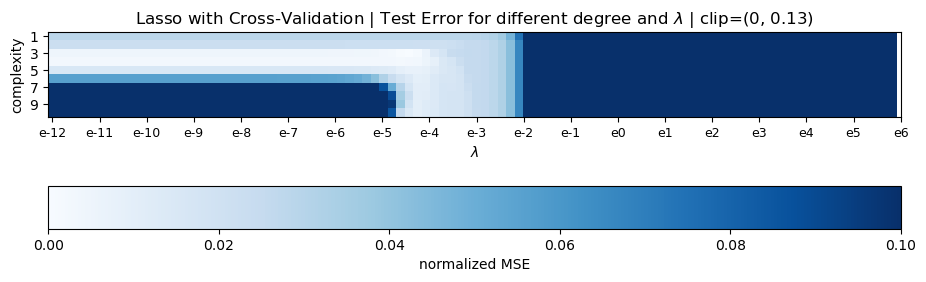

In [154]:
data_to_plot = np.clip(record['mse_test'], 0, 0.1).T

fig_cv, ax = plt.subplots(figsize=(11, 6))
cmap = cm.get_cmap("Blues")
norm = plt_colors.Normalize(0, data_to_plot.max())

ax.set_title(f"Lasso with Cross-Validation | Test Error for different degree and $\lambda$ | clip=(0, 0.13)")

ax.imshow(data_to_plot, cmap=cmap)

ax.set_ylabel('complexity')
ax.set_xlabel('$\lambda$')

# plot colorbar
fig_cv.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, location="bottom", label="normalized MSE")

#fig.colorbar(pos, ax)
lambdas_labels = [f"e{i}" for i in range(-12, 7)]
ax.set_xticks(np.linspace(0, nb_lambdas, len(lambdas_labels)))
ax.set_xticklabels(lambdas_labels, fontsize=9)
ax.set_yticks(range(0, len(degrees), 2))
ax.set_yticklabels(range(1, 11, 2))
plt.show()